# Import the Libraries

In [816]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import math
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from langdetect import detect

# Understanding the Data

In [817]:
df = pd.read_csv("calm_us.csv")
df.head()

,Unnamed: 0,date,rating,review,title,developerResponse.body
0,0,2020-07-07 22:44:10,5,"I had a wonderful 2018, but mid 2019 my world ...",Learning how to self love,"Hello, we are all in a very chaotic time with ..."
1,1,2020-07-09 10:01:22,5,This app has brought a new meaning of gratitud...,Loving yourself unconditional,"Hello, thank you so much for profoundly sharin..."
2,2,2020-06-17 03:15:08,5,Never in 1 million years did I think I would m...,Game changer,What a profound comment! We don't always have ...
3,3,2020-08-02 13:45:00,5,I’ve used three or four of the other popular m...,Best in class meditation app,"Hello Ernie, thank you so much for this uplift..."
4,4,2020-03-03 12:07:14,5,I work night shift and on my days off it’s ver...,Melatonin at its finest.,"Hello, it is great to hear that you liked Medi..."


In [818]:
# unnamed is just a duplicate of the index
df.drop('Unnamed: 0', axis=1, inplace=True)

In [819]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date                    236 non-null    object
 1   rating                  236 non-null    int64 
 2   review                  236 non-null    object
 3   title                   236 non-null    object
 4   developerResponse.body  193 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.3+ KB


In [820]:
df.describe()

,rating
count,236.000000
mean,4.419492
std,1.326442
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [821]:
# look at the dates separately
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df = df.drop(columns=["date"])
df.head()

,rating,review,title,developerResponse.body,year,month,day
0,5,"I had a wonderful 2018, but mid 2019 my world ...",Learning how to self love,"Hello, we are all in a very chaotic time with ...",2020,7,7
1,5,This app has brought a new meaning of gratitud...,Loving yourself unconditional,"Hello, thank you so much for profoundly sharin...",2020,7,9
2,5,Never in 1 million years did I think I would m...,Game changer,What a profound comment! We don't always have ...,2020,6,17
3,5,I’ve used three or four of the other popular m...,Best in class meditation app,"Hello Ernie, thank you so much for this uplift...",2020,8,2
4,5,I work night shift and on my days off it’s ver...,Melatonin at its finest.,"Hello, it is great to hear that you liked Medi...",2020,3,3


In [822]:
df = df.rename(columns={'developerResponse.body': "calm response"})
df.head()

,rating,review,title,calm response,year,month,day
0,5,"I had a wonderful 2018, but mid 2019 my world ...",Learning how to self love,"Hello, we are all in a very chaotic time with ...",2020,7,7
1,5,This app has brought a new meaning of gratitud...,Loving yourself unconditional,"Hello, thank you so much for profoundly sharin...",2020,7,9
2,5,Never in 1 million years did I think I would m...,Game changer,What a profound comment! We don't always have ...,2020,6,17
3,5,I’ve used three or four of the other popular m...,Best in class meditation app,"Hello Ernie, thank you so much for this uplift...",2020,8,2
4,5,I work night shift and on my days off it’s ver...,Melatonin at its finest.,"Hello, it is great to hear that you liked Medi...",2020,3,3


## Analyzing MultiLingual Data

In [823]:
df.tail()

,rating,review,title,calm response,year,month,day
231,1,So I downloaded this and it was a SEVEN day FR...,Charged me $60.00 the day before,"Hello, sorry for your situation. Payments are ...",2019,7,26
232,5,"So well done, I couldn’t sleep then I was in Y...",So relaxing,So great to see your comment :) Thanks for sha...,2019,5,9
233,5,I was agitated and felt frustration creeping u...,More relax,NaN,2021,3,3
234,1,"Be careful with this APP, after using it for a...",Be careful with this app,Being aware and being careful are two of the g...,2019,2,9
235,1,5 yıldız verenlerin hepsi komisyon alıyor sanı...,Yalan dolan!,NaN,2017,2,9


As it can be seen in line 235, there are also some non-English tweets. Let's identify them.

In [824]:
words = set(nltk.corpus.words.words())

In [825]:
for line in df["review"]:
    for word in line:
        if word in words: # Comparing if word is non-English
            df["lang"] = "eng"
        else:
            df["lang"] = "non-eng"
df

,rating,review,title,calm response,year,month,day,lang
0,5,"I had a wonderful 2018, but mid 2019 my world ...",Learning how to self love,"Hello, we are all in a very chaotic time with ...",2020,7,7,non-eng
1,5,This app has brought a new meaning of gratitud...,Loving yourself unconditional,"Hello, thank you so much for profoundly sharin...",2020,7,9,non-eng
2,5,Never in 1 million years did I think I would m...,Game changer,What a profound comment! We don't always have ...,2020,6,17,non-eng
3,5,I’ve used three or four of the other popular m...,Best in class meditation app,"Hello Ernie, thank you so much for this uplift...",2020,8,2,non-eng
4,5,I work night shift and on my days off it’s ver...,Melatonin at its finest.,"Hello, it is great to hear that you liked Medi...",2020,3,3,non-eng
...,...,...,...,...,...,...,...,...
231,1,So I downloaded this and it was a SEVEN day FR...,Charged me $60.00 the day before,"Hello, sorry for your situation. Payments are ...",2019,7,26,non-eng
232,5,"So well done, I couldn’t sleep then I was in Y...",So relaxing,So great to see your comment :) Thanks for sha...,2019,5,9,non-eng
233,5,I was agitated and felt frustration creeping u...,More relax,NaN,2021,3,3,non-eng
234,1,"Be careful with this APP, after using it for a...",Be careful with this app,Being aware and being careful are two of the g...,2019,2,9,non-eng


This approach will not work since some English are not typed correctly. Let's try to identify languages using langdetect library.

In [826]:
df = df.drop(columns=["lang"])

In [827]:
lang = []
for i in df["review"]:
    lang.append(detect(i))

In [828]:
df["lang"] = lang

In [829]:
df.tail()

,rating,review,title,calm response,year,month,day,lang
231,1,So I downloaded this and it was a SEVEN day FR...,Charged me $60.00 the day before,"Hello, sorry for your situation. Payments are ...",2019,7,26,en
232,5,"So well done, I couldn’t sleep then I was in Y...",So relaxing,So great to see your comment :) Thanks for sha...,2019,5,9,en
233,5,I was agitated and felt frustration creeping u...,More relax,NaN,2021,3,3,en
234,1,"Be careful with this APP, after using it for a...",Be careful with this app,Being aware and being careful are two of the g...,2019,2,9,en
235,1,5 yıldız verenlerin hepsi komisyon alıyor sanı...,Yalan dolan!,NaN,2017,2,9,tr


In [830]:
df[df["lang"] != "en"]

,rating,review,title,calm response,year,month,day,lang
89,5,So fun,Help me go to sleep in like three minutes,"Hello, it is great to hear that you liked Medi...",2020,1,26,es
90,5,Calming beautiful voice.,It really helps!,NaN,2018,4,17,ro
131,5,Relaxing 😌,Determination,Thank you so much for your comment :) Meditati...,2019,8,15,tl
140,5,"Agüita fresca de manantial, para tu alma..",Agua fresca,NaN,2020,7,11,ca
141,5,AAA+,Awesome meditation app,Thank you so much 🙏 Have a great week! All the...,2018,11,9,hu
...,...,...,...,...,...,...,...,...
220,5,Excelente app me gusta y me motiva a seguir to...,Excelente,Es increible aprenderlo! Espero que la app sie...,2019,1,28,es
221,5,"Es la mejor app que me e descargado, me relaja...",Me enamoré,Perfecto! Espero que la app siempe le ayudará ...,2019,1,8,es
222,5,Recomendada,Excelente,¡Hola Jesús! Nos da gusto saber que te ha gust...,2019,1,6,pt
224,1,Uygulama bir haftalık ücretsiz deneme süresind...,İsteğim dışında abone olmuşum,NaN,2017,10,19,tr


As we can see, there are still some errors, but better.

In [831]:
df.groupby(by="lang").mean()

,rating,year,month,day
lang,,,,
ca,5.000000,2020.000000,6.500000,15.500000
en,4.209459,2019.763514,5.405405,16.790541
es,4.906250,2019.687500,6.125000,17.500000
fi,5.000000,2019.000000,2.000000,16.000000
hu,5.000000,2018.000000,11.000000,9.000000
id,5.000000,2019.000000,2.000000,16.000000
pt,4.833333,2019.833333,3.333333,11.666667
ro,5.000000,2018.000000,4.000000,17.000000
ru,4.600000,2020.000000,7.800000,10.400000


### Correlation

In [832]:
# see if there is a correlation on the numeric data
correlation = df.corr()
correlation

,rating,year,month,day
rating,1.000000,0.076995,-0.042329,-0.045868
year,0.076995,1.000000,-0.230126,-0.036212
month,-0.042329,-0.230126,1.000000,0.010710
day,-0.045868,-0.036212,0.010710,1.000000


In [833]:
df["year"].min()

2017

In [834]:
df["year"].max()

2021

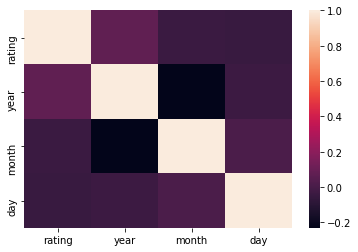

In [835]:
# visualize (there is no correlation)
sns.heatmap(correlation)
plt.show()

## Data Visualization

In [836]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         236 non-null    int64 
 1   review         236 non-null    object
 2   title          236 non-null    object
 3   calm response  193 non-null    object
 4   year           236 non-null    int64 
 5   month          236 non-null    int64 
 6   day            236 non-null    int64 
 7   lang           236 non-null    object
dtypes: int64(4), object(4)
memory usage: 14.9+ KB


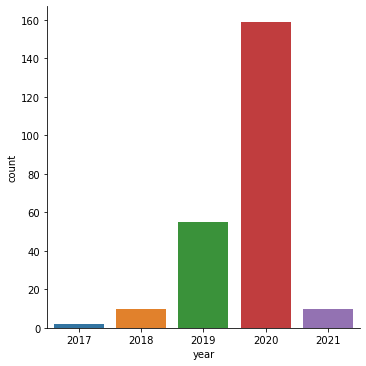

In [837]:
sns.catplot(x="year",data=df,kind="count")
plt.show()

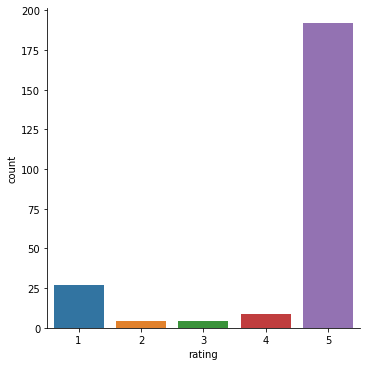

In [838]:
sns.catplot(x="rating",data=df,kind="count")
plt.show()

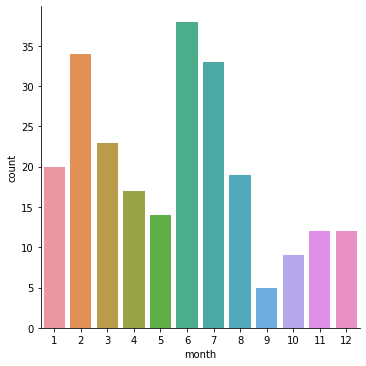

In [839]:
sns.catplot(x="month",data=df,kind="count")
plt.show()

# Analysing Reviews

In [840]:
df['review'] = df['review'].str.replace('[^\w\s]','')
df['review'] = df['review'].str.lower()
df.head()

,rating,review,title,calm response,year,month,day,lang
0,5,i had a wonderful 2018 but mid 2019 my world s...,Learning how to self love,"Hello, we are all in a very chaotic time with ...",2020,7,7,en
1,5,this app has brought a new meaning of gratitud...,Loving yourself unconditional,"Hello, thank you so much for profoundly sharin...",2020,7,9,en
2,5,never in 1 million years did i think i would m...,Game changer,What a profound comment! We don't always have ...,2020,6,17,en
3,5,ive used three or four of the other popular me...,Best in class meditation app,"Hello Ernie, thank you so much for this uplift...",2020,8,2,en
4,5,i work night shift and on my days off its very...,Melatonin at its finest.,"Hello, it is great to hear that you liked Medi...",2020,3,3,en


In [841]:
df.isna().sum()

rating            0
review            0
title             0
calm response    43
year              0
month             0
day               0
lang              0
dtype: int64

Calm hasn't responded some of the reviews. Check if there is a relation between comments Calm answered and ratings/

In [842]:
no_calm_df = df[df['calm response'].isna()]

In [843]:
corr = no_calm_df.corr()
corr

,rating,year,month,day
rating,1.000000,0.479442,0.038433,0.102715
year,0.479442,1.000000,-0.186690,-0.085800
month,0.038433,-0.186690,1.000000,0.216380
day,0.102715,-0.085800,0.216380,1.000000


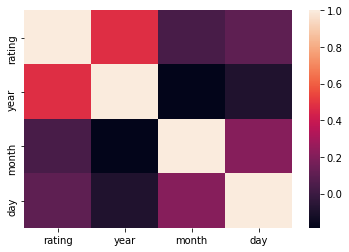

In [844]:
sns.heatmap(corr)
plt.show()

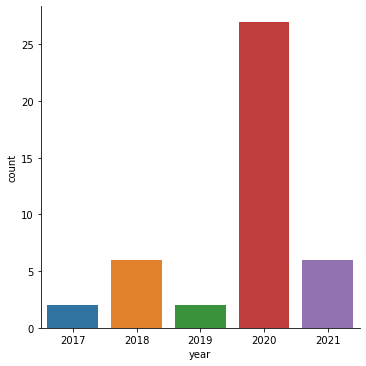

In [845]:
sns.catplot(x="year",data=no_calm_df,kind="count")
plt.show()

## Word Cloud

I will only check English tweets.

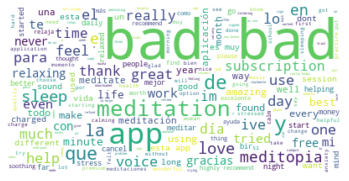

In [846]:
text = " ".join(review for review in df.review)
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [847]:
df_1 = df[(df["rating"] == 1) & (df["lang"] == "en")]
df_2 = df[(df["rating"] == 2) & (df["lang"] == "en")]
df_3 = df[(df["rating"] == 3) & (df["lang"] == "en")]
df_4 = df[(df["rating"] == 4) & (df["lang"] == "en")]
df_5 = df[(df["rating"] == 5) & (df["lang"] == "en")]

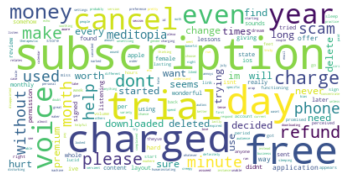

In [848]:
text = " ".join(review for review in df_1.review)
stopwords = set(STOPWORDS)
stopwords.update(["meditation", "app", "meditate"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

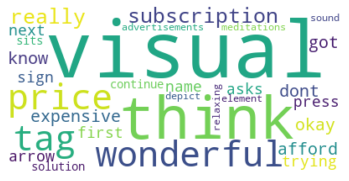

In [849]:
text = " ".join(review for review in df_2.review)
stopwords = set(STOPWORDS)
stopwords.update(["meditation", "app", "meditate", "thing", "im"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

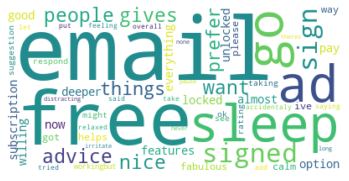

In [850]:
text = " ".join(review for review in df_3.review)
stopwords = set(STOPWORDS)
stopwords.update(["meditation", "app", "meditate", "im", "meditations"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

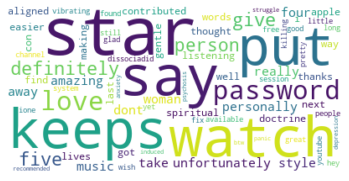

In [851]:
text = " ".join(review for review in df_4.review)
stopwords = set(STOPWORDS)
stopwords.update(["meditation", "app", "meditate", "meditations", "one"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

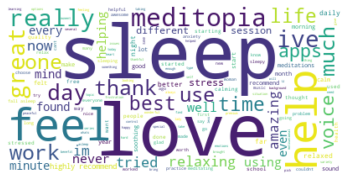

In [852]:
text = " ".join(review for review in df_5.review)
stopwords = set(STOPWORDS)
stopwords.update(["meditation", "app", "meditate"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Implementing TF-IDF (using scikit-learn)

In [853]:
list_1 = pd.Series.to_list(df_1["review"])
list_2 = pd.Series.to_list(df_2["review"])
list_3 = pd.Series.to_list(df_3["review"])
list_4 = pd.Series.to_list(df_4["review"])
list_5 = pd.Series.to_list(df_5["review"])

In [854]:
def tf_idf(data):
    tfIdfVectorizer=TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform(data)
    df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values("TF-IDF", ascending=False)
    print(df.head())

In [855]:
tf_idf(list_1)

             TF-IDF
voices     0.283228
somehow    0.213355
wonderful  0.213355
female     0.213355
the        0.191201


In [856]:
tf_idf(list_2)

             TF-IDF
wonderful  0.247518
think      0.247518
really     0.247518
price      0.247518
afford     0.247518


In [857]:
tf_idf(list_3)

       TF-IDF
to   0.329127
is   0.259657
and  0.197476
you  0.197476
but  0.197476


In [858]:
tf_idf(list_4)

               TF-IDF
stars        0.278406
the          0.247751
meditations  0.228297
one          0.228297
are          0.228297


In [859]:
tf_idf(list_5)

         TF-IDF
my     0.302868
am     0.206464
and    0.170684
to     0.163982
which  0.155377
